In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import scipy as sp

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [2]:
data_path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Clinical projects/PeskindTBI/final_data/first_visits_short.csv'

In [3]:
#read in csv containing data from all surveys and all visitseqs
data = pd.read_csv(data_path, index_col=0)
data = pd.DataFrame(data = data)

print('Original data shape:\n', data.shape, '\n')
print(data.info())
data.head(1)

Original data shape:
 (213, 163) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 212
Columns: 163 entries, Status_x to Plasma1_VEGFD
dtypes: float64(152), int64(3), object(8)
memory usage: 272.9+ KB
None


,Status_x,VisitSeq,Group,TBIID,EntityID,DOB,GType,Race,Hispanic,Handedness,ScreenAge,Education,Marital,APOEGen,servconn,cestotal,MnthSncBlst,QKOIorA,QKOExpMil,QKOAllMil,QKOLife,QBlstExp,QBEACRM,Q5plus2,QEDist_sum,QEDist_mean,QEDist_min,auditc,AUDIT1,AUDIT2,AUDIT3,DOPA,DA,DOPAC,NE,DHPG,da_dopa_ratio,dopac_da_ratio,ne_dopa_ratio,dhpg_ne_ratio,HEIGHT,WEIGHT,BMI,BPSYS,BPDIAS,HRATE,HYPERTEN,HYPERCHO,DIABETES,B12DEF,THYROID,BGlucose,BNa,BUN,BCreat,BOsmo,UOsmo,USG,UNa,BK,TotalChol,LDL,HDL,Trig,CSFPROTEIN_x,CSFGLUCOSE,CSFRBCS,MHxPain,MHxHA,MHxHtn,MHxCard,MHxGI,MHxNeuro,MHxLung,MHxApnea,SCPTSD,SCMDD,SCPD,SCGAD,SCNone,DvpHA,DvpHAAct,DvpHASlp,DvpHAMd,DvpHAStr,DvpBP,DvpBPAct,DvpBPslp,DvpBPMd,DvpBPStr,BISAtt,BISMtr,BISNonpl,BISTot,capsCrtA,CAPSTotal,PSQIc1,PSQIc2,PSQIc3,PSQIc4,PSQIc5,PSQIc6,PSQIc7,PSQItot,PCLTot,PCL_reexp,PCL_avoid,PCL_numb,PCL_hyper,PHQTot,PHQ_psych,PHQ_somatic,NSITot,TBITot,NSI_vestibular,NSI_somatosensory,NSI_cognitive,NSI_affective,NSI_ERP_affective,NIS_ERP_vestsom,PreSleep,PreCaff,PreETOH,PreNic,PreTHC,Amygdala_l,Amygdala_r,Pallidum_l,Pallidum_r,Midbrain,Plasma1_bFGF,Plasma1_CRP,Plasma1_Eotaxin,Plasma1_Eotaxin3,Plasma1_Flt1,Plasma1_ICAM1,Plasma1_IFNγ,Plasma1_IL10,Plasma1_IL12_IL23p40,Plasma1_IL12p70,Plasma1_IL15,Plasma1_IL16,Plasma1_IL17A,Plasma1_IL1α,Plasma1_IL6,Plasma1_IL7,Plasma1_IL8,Plasma1_IP10,Plasma1_MCP1,Plasma1_MCP4,Plasma1_MDC,Plasma1_MIP1α,Plasma1_MIP1β,Plasma1_PlGF,Plasma1_SAA,Plasma1_TARC,Plasma1_Tie2,Plasma1_TNFα,Plasma1_TNFβ,Plasma1_VCAM1,Plasma1_VEGF,Plasma1_VEGFC,Plasma1_VEGFD
0,Lost to F/U,1,C,C002,2904,1968-12-06,M12,White,0.0,2.0,26,12.0,Married,"2,3",0.0,7.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,459.0,18.0,303.0,40.0,1544.0,0.039216,16.833333,0.087146,38.6,75.0,268.0,33.5,142.0,92.0,54.0,0.0,0.0,0.0,0.0,0.0,104.0,143.0,11.0,0.96,NaN,NaN,1.015,NaN,4.4,NaN,NaN,NaN,NaN,52.0,50.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,17.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.676899,0.669192,0.835282,0.837992,0.754134,4.7,2727105.14,86.92,16.43,75.78,595287.3,2.87,0.37,139.57,0.13,1.51,153.25,3.9,0.78,0.57,1.53,2.81,375.61,39.44,45.12,652.58,33.62,50.6,8.25,2687944.76,29.0,1389.23,3.21,0.63,514421.61,37.59,40.23,259.14


In [4]:
#select which groups to viz
TBIID_to_keep = ['C', 'T']
print(data['Group'].value_counts())
data = data[data['Group'].isin(TBIID_to_keep)]
print(data['Group'].value_counts())

T    160
C     53
Name: Group, dtype: int64
T    160
C     53
Name: Group, dtype: int64


In [5]:
#determined outliers for auditc and QBlstExp (outlier = >3 SD from mean) and remove
data = data[data["TBIID"] != 'C010']
data = data[data["TBIID"] != 'T080']

In [18]:
#create variable lists depending on data type for graphing purposes

data['HDL_LDL_ratio'] = data['HDL'] / data['LDL']

data_cont = ['ScreenAge', 'Education', 'servconn', 'cestotal',
       'MnthSncBlst', 'QKOIorA', 'QKOExpMil', 'QKOAllMil', 'QKOLife',
       'QBlstExp', 'QBEACRM', 'Q5plus2', 'QEDist_sum', 'QEDist_mean',
       'QEDist_min', 'DOPA', 'DA', 'DOPAC', 'NE', 'DHPG', 'da_dopa_ratio', 'dopac_da_ratio',
       'ne_dopa_ratio', 'dhpg_ne_ratio', 
       'CAPSTotal', 'PSQIc1', 'PSQIc2', 'PSQIc3', 'PSQIc4', 'PSQIc5',
       'PSQIc6', 'PSQIc7', 'PSQItot', 'PCLTot', 'PCL_reexp', 'PCL_avoid',
       'PCL_numb', 'PCL_hyper', 'PHQTot', 'PHQ_psych', 'PHQ_somatic',
       'NSITot', 'TBITot', 'NSI_vestibular', 'NSI_somatosensory',
       'NSI_cognitive', 'NSI_affective', 'NSI_ERP_affective',
       'NIS_ERP_vestsom', 'DvpHA', 'DvpHAAct', 'DvpHASlp',
       'DvpHAMd', 'DvpHAStr', 'DvpBP', 'DvpBPAct', 'DvpBPslp', 'DvpBPMd',
       'DvpBPStr', 'BISAtt', 'BISMtr', 'BISNonpl', 'BISTot',
             'PreSleep', 'PreCaff', 'PreETOH', 'PreNic', 'PreTHC']

health_cont = ['HEIGHT', 'WEIGHT', 'BMI',
       'BPSYS', 'BPDIAS', 'HRATE', 'BGlucose', 'BNa', 'BUN', 'BCreat', 'UNa',
       'BK', 'TotalChol', 'LDL', 'HDL', 'HDL_LDL_ratio', 'Trig', 'CSFPROTEIN_x',
       'CSFGLUCOSE', 'CSFRBCS']

data_cat = ['Status_x', 'VisitSeq', 'GType', 'Race', 'Hispanic', 'Handedness', 'Marital', 'APOEGen', 
           'HYPERTEN', 'HYPERCHO', 'DIABETES', 'B12DEF', 'THYROID',
           'MHxPain', 'MHxHA', 'MHxHtn', 'MHxCard', 'MHxGI', 'MHxNeuro', 'MHxLung', 'MHxApnea', 
            'SCPTSD', 'SCMDD', 'SCPD', 'SCGAD', 'SCNone', 'capsCrtA']

data_audit = ['auditc', 'AUDIT1', 'AUDIT2', 'AUDIT3']

data_v1 = data[data['VisitSeq'] == 1]

HEIGHT
Ttest_indResult(statistic=1.5844038547140675, pvalue=0.11540750529457969)


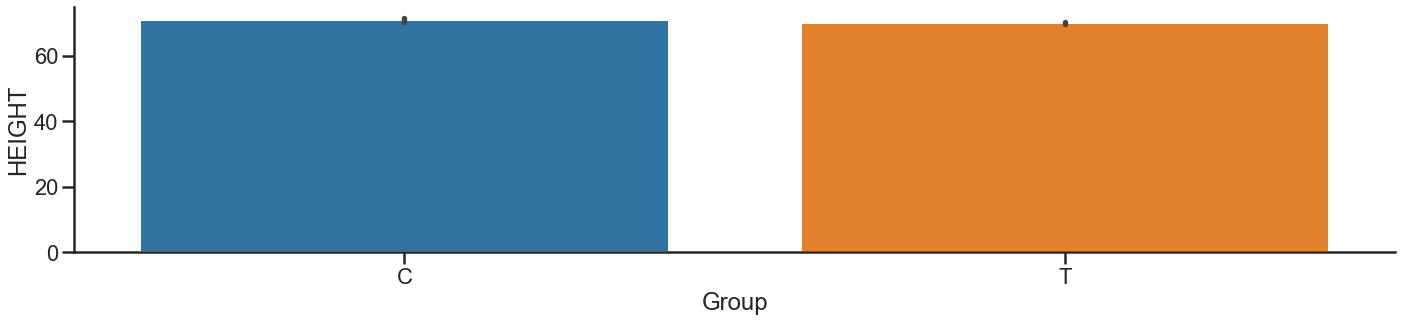



WEIGHT
Ttest_indResult(statistic=-1.1181093415730794, pvalue=0.26547709338700903)


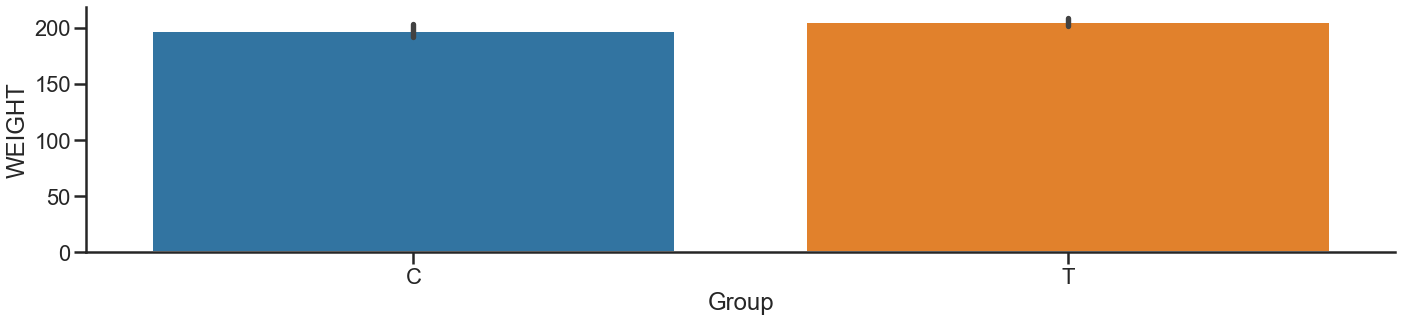



BMI
Ttest_indResult(statistic=-2.067791206274396, pvalue=0.04054108048414705)


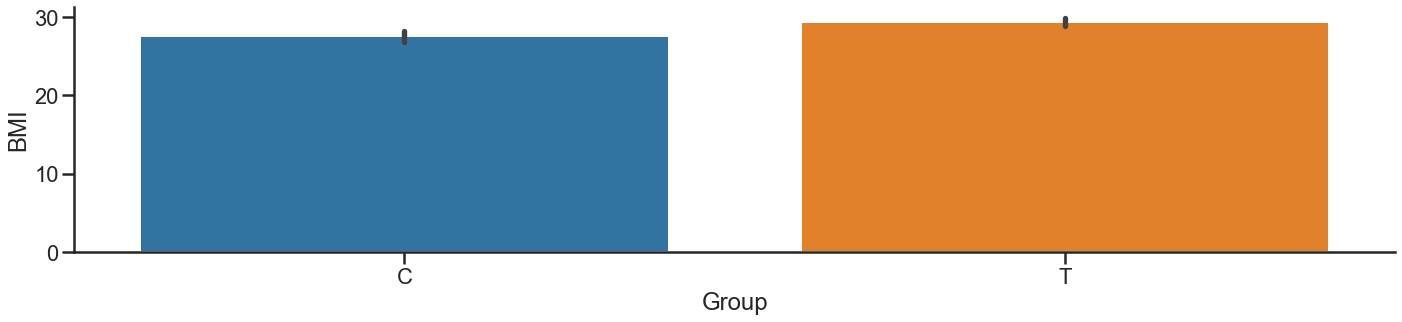



BPSYS
Ttest_indResult(statistic=0.9013664142219157, pvalue=0.3690228902825443)


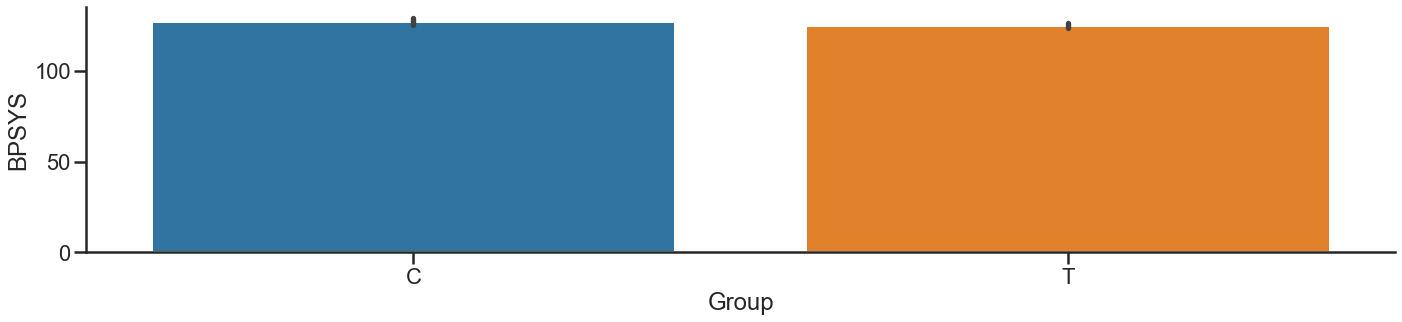



BPDIAS
Ttest_indResult(statistic=-0.5747032258783815, pvalue=0.5664628709877162)


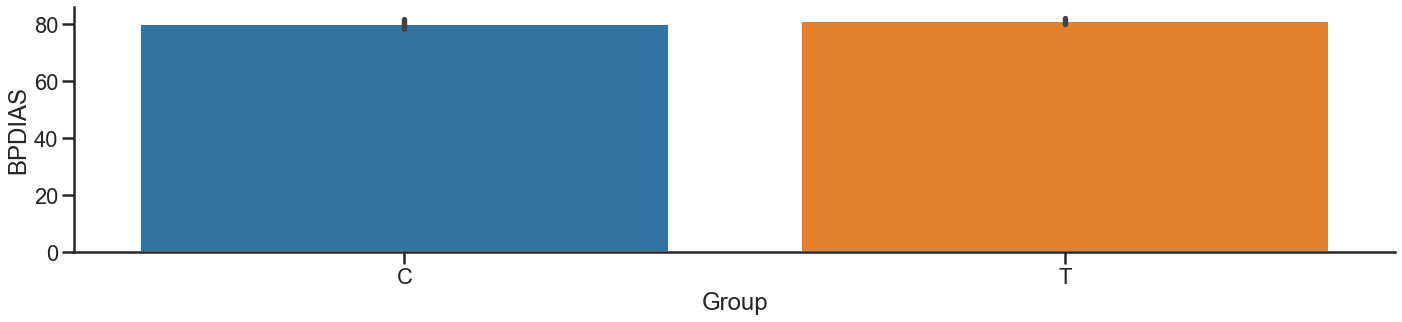



HRATE
Ttest_indResult(statistic=-1.5164160830652424, pvalue=0.13178739547470658)


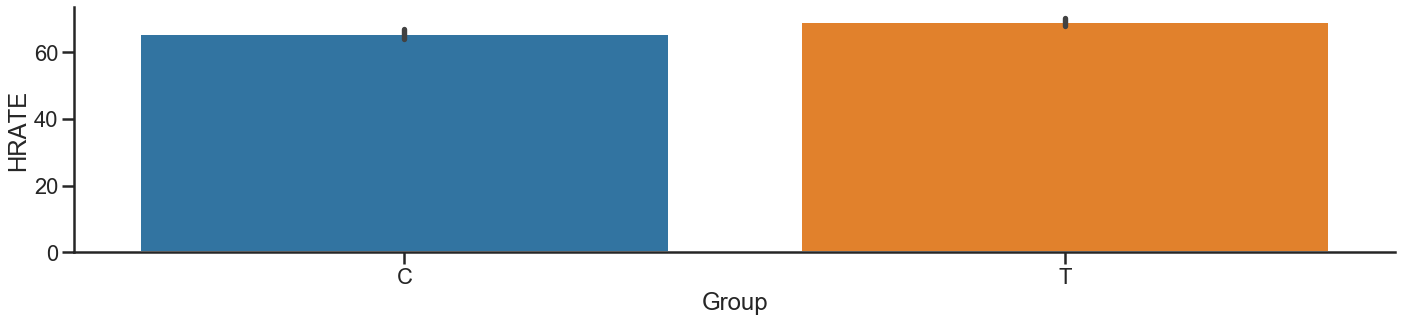



BGlucose
Ttest_indResult(statistic=-1.6055047267583566, pvalue=0.11073690933435465)


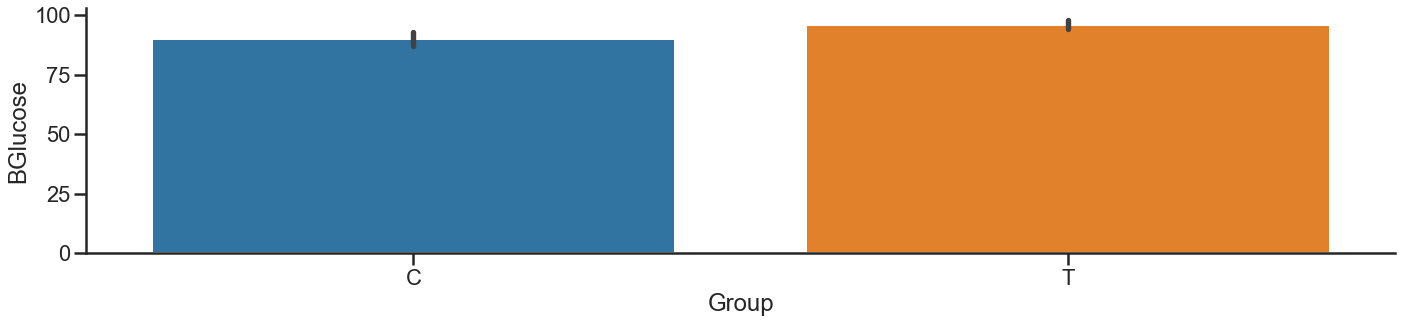



BNa
Ttest_indResult(statistic=-0.34446603803026804, pvalue=0.7310358452381377)


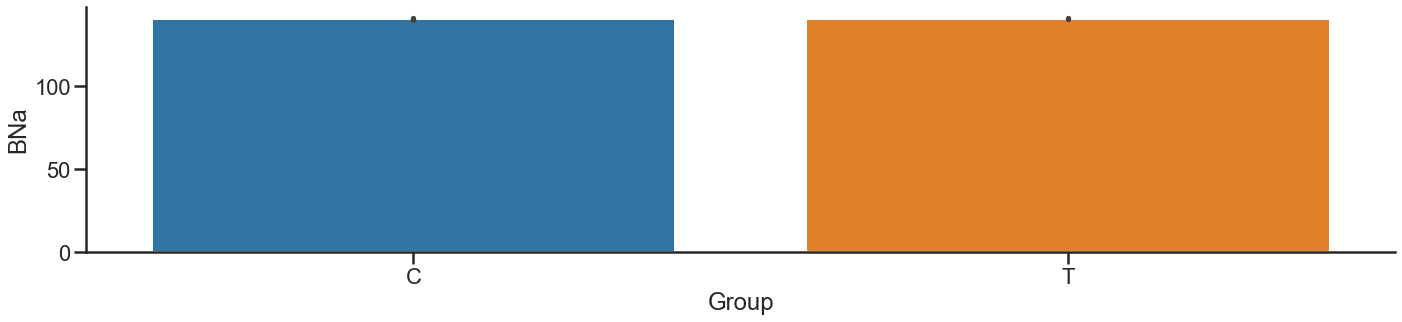



BUN
Ttest_indResult(statistic=-0.9381753861629302, pvalue=0.34984221323941345)


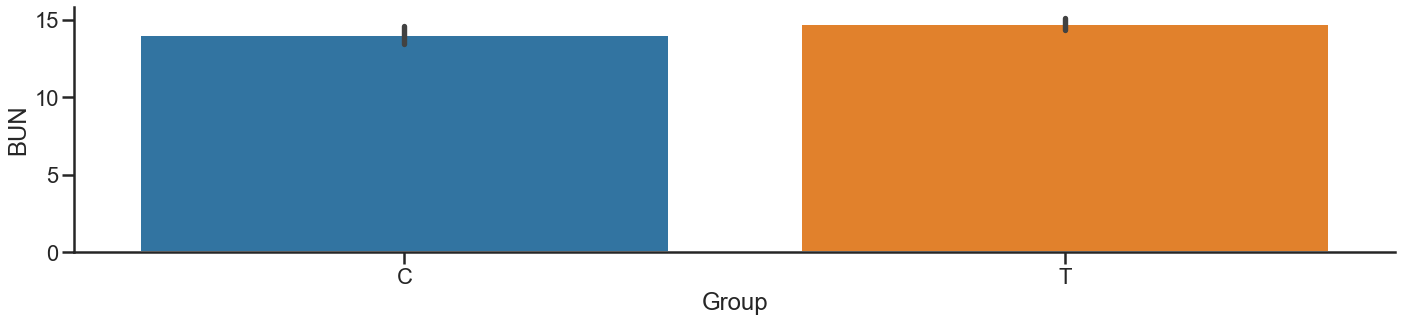



BCreat
Ttest_indResult(statistic=-0.7743763509898742, pvalue=0.4400724507396454)


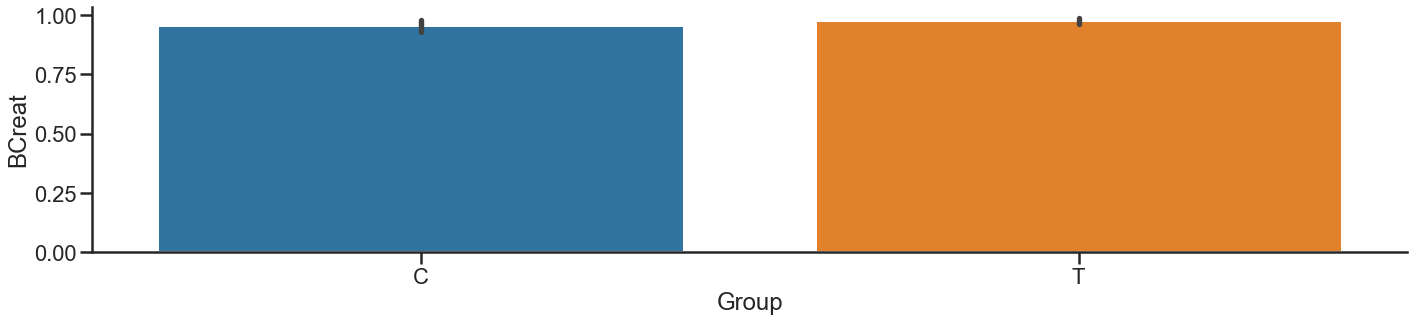



UNa
Ttest_indResult(statistic=nan, pvalue=nan)


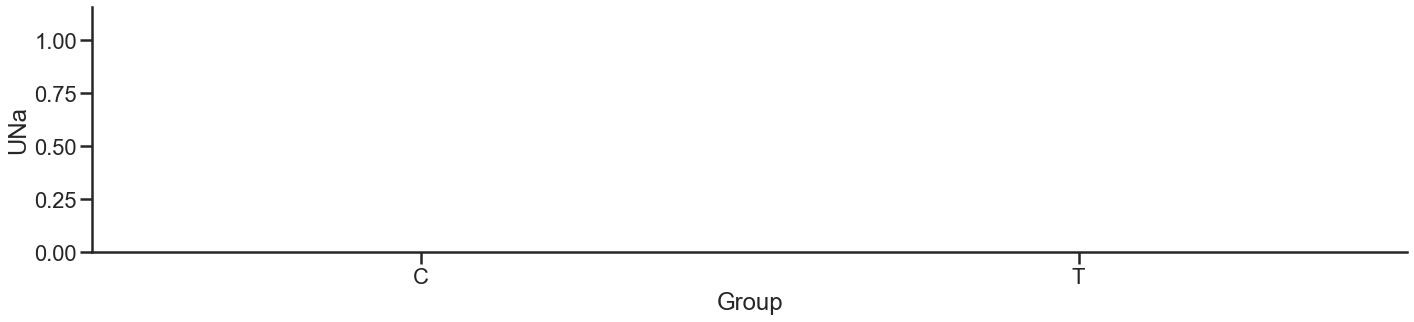



BK
Ttest_indResult(statistic=0.03380520743904736, pvalue=0.9730827867860949)


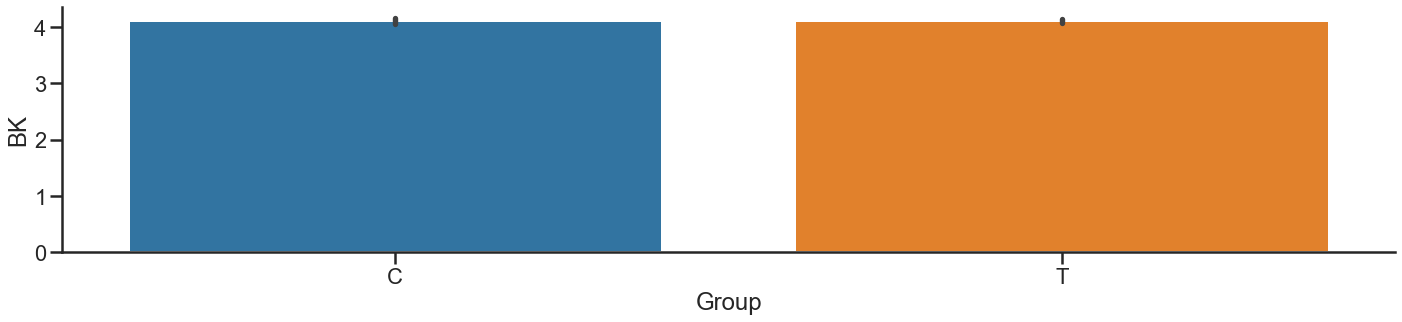



TotalChol
Ttest_indResult(statistic=-0.595126933622468, pvalue=0.5548072224605128)


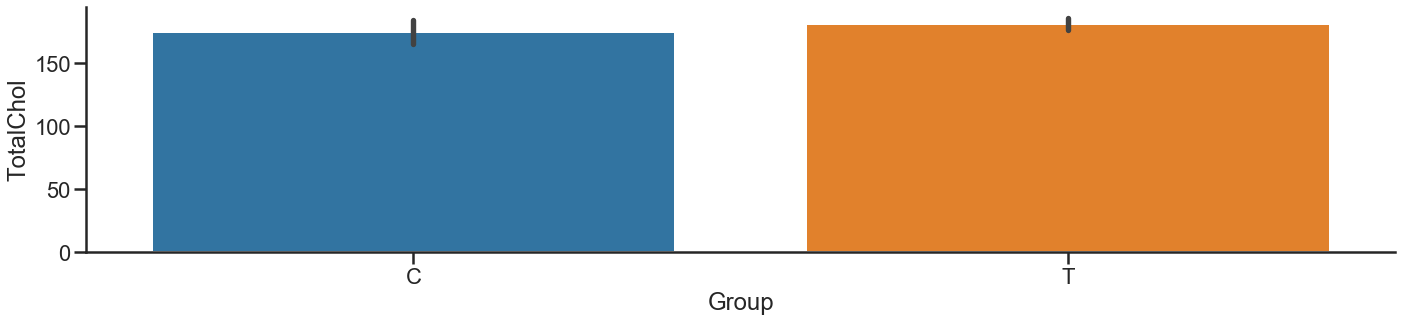



LDL
Ttest_indResult(statistic=-0.7154370908694174, pvalue=0.4782059847645299)


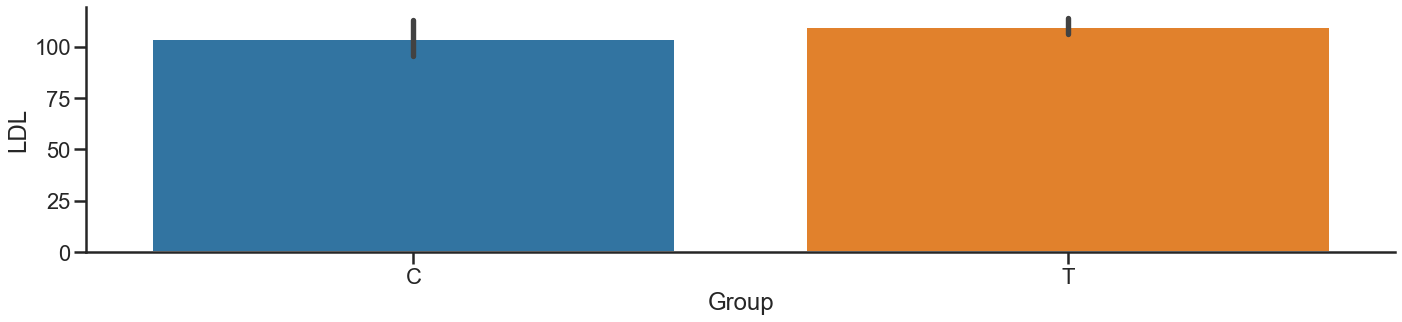



HDL
Ttest_indResult(statistic=0.42914095263782925, pvalue=0.6699146580195497)


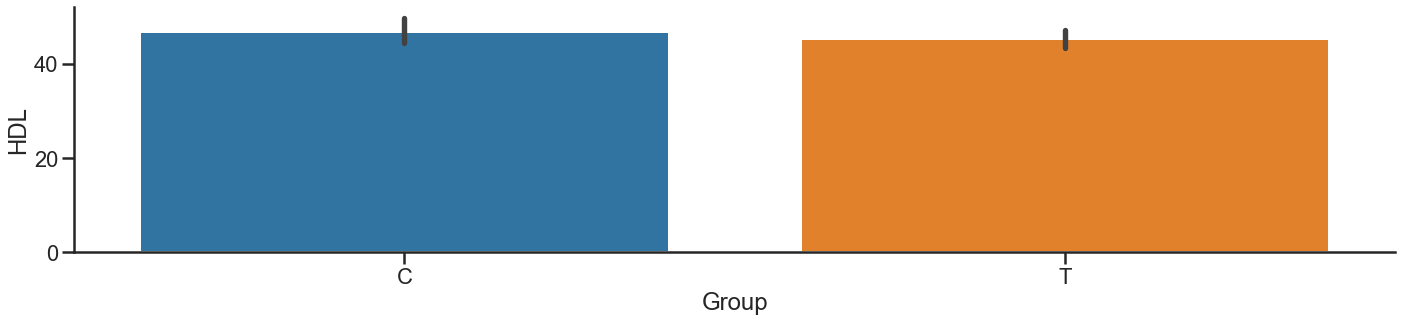



HDL_LDL_ratio
Ttest_indResult(statistic=1.3914282315554247, pvalue=0.17125279071791855)


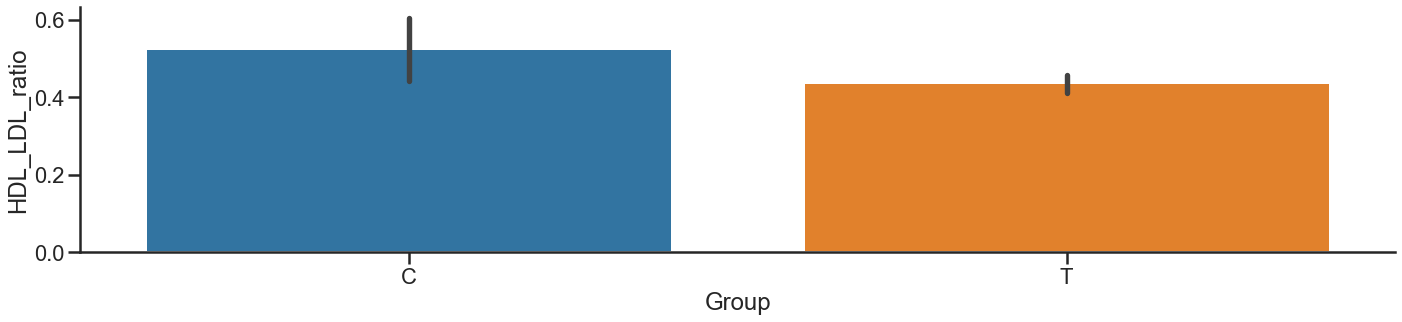



Trig
Ttest_indResult(statistic=-0.5439675456994765, pvalue=0.5892097816101776)


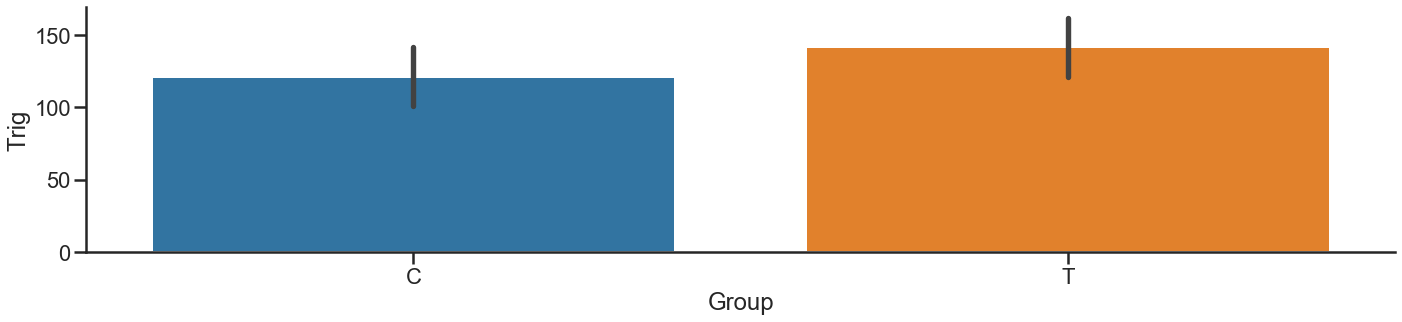



CSFPROTEIN_x
Ttest_indResult(statistic=-1.431820338396008, pvalue=0.15658290024760851)


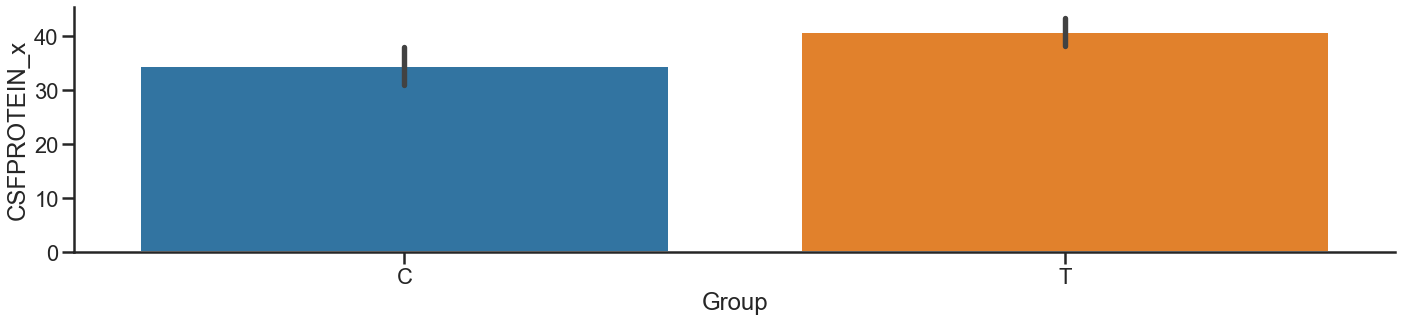



CSFGLUCOSE
Ttest_indResult(statistic=-2.2684356141980877, pvalue=0.026345237953820363)


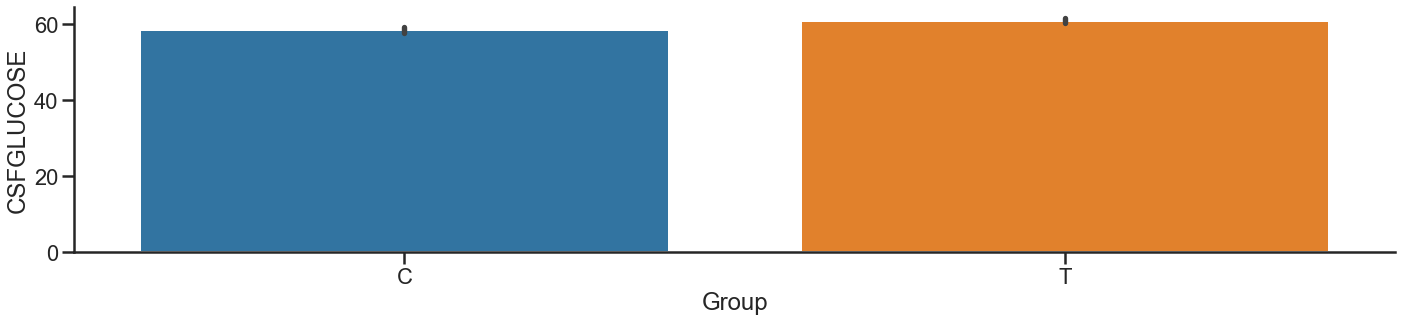



CSFRBCS
Ttest_indResult(statistic=-0.40009564292957, pvalue=0.6903044320134926)


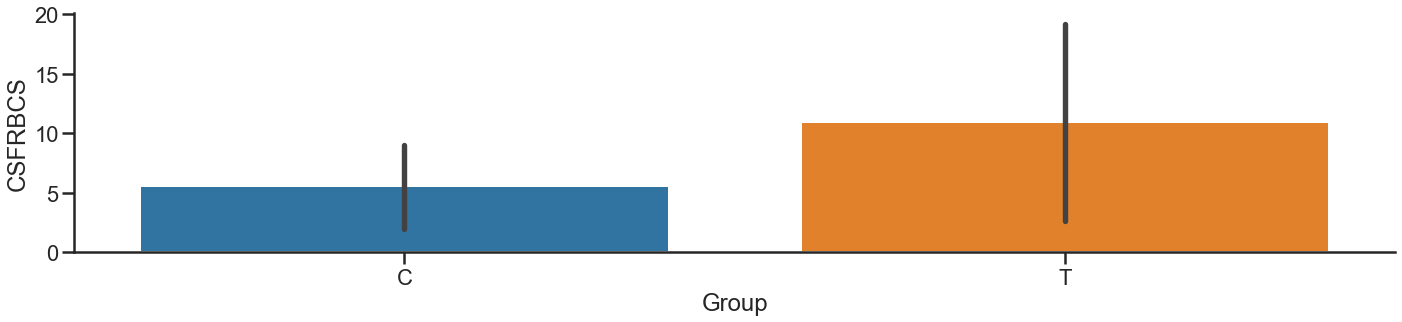

In [16]:
for param in health_cont:
    print(param)
    
    try:
        #t-test
        C = data_v1[data_v1['Group'] == 'C'][param].dropna()
        T = data_v1[data_v1['Group'] == 'T'][param].dropna()
        print(sp.stats.ttest_ind(C, T, axis=0, equal_var=True))
        
        g = sns.catplot(x='Group', y=param, kind='bar', data=data_v1, ci=68, height=5, aspect=4)
        plt.show()
        
        print('\n')
        
    except:
        pass

Status_x


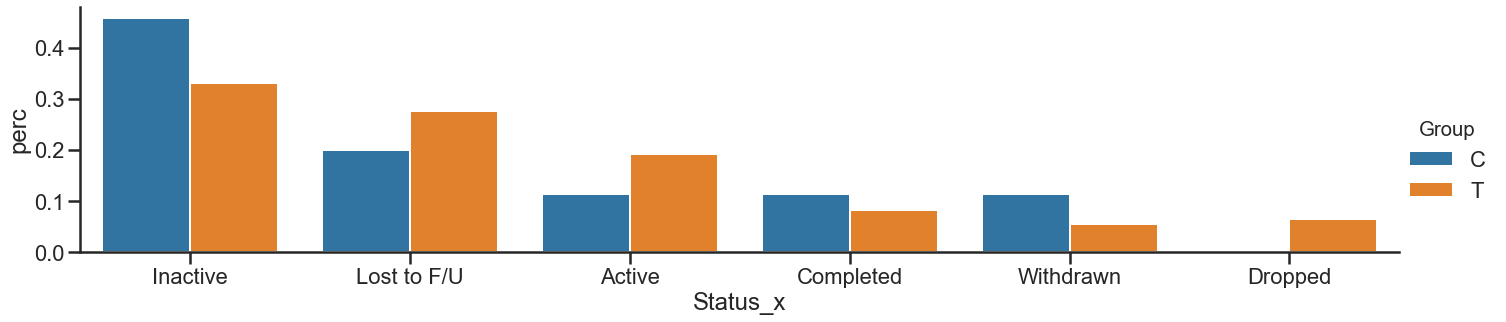



VisitSeq


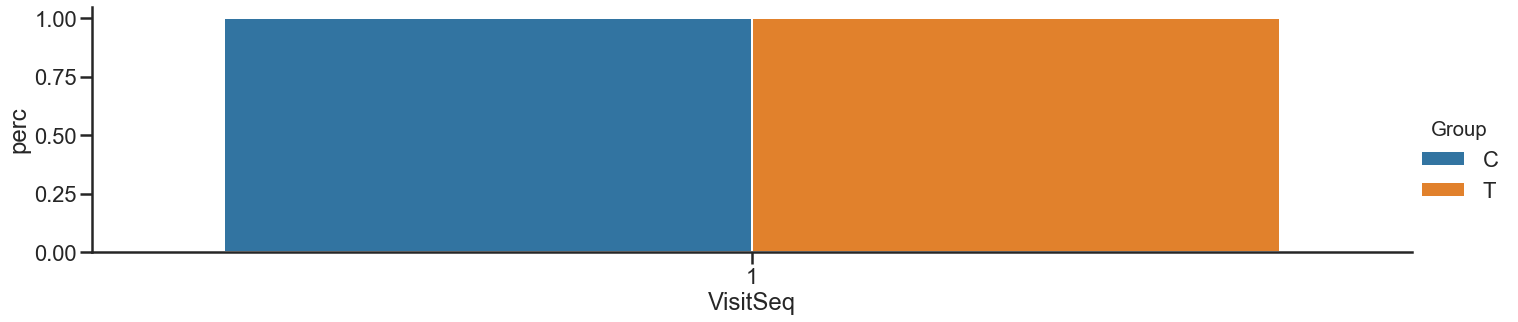



GType


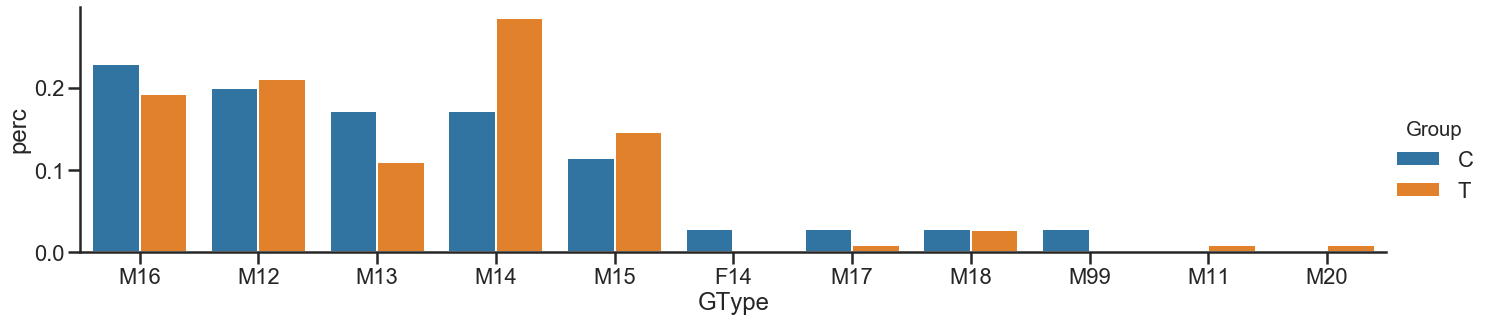



Race


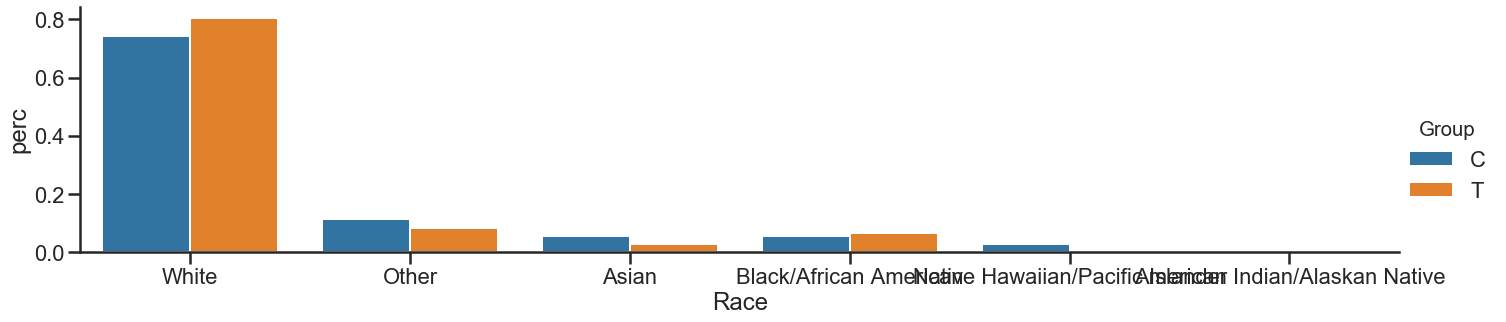



Hispanic


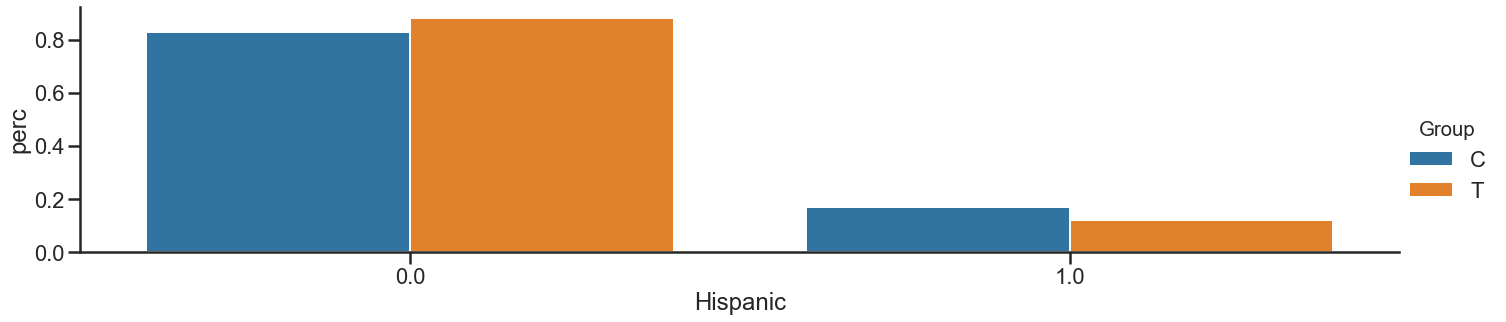



Handedness


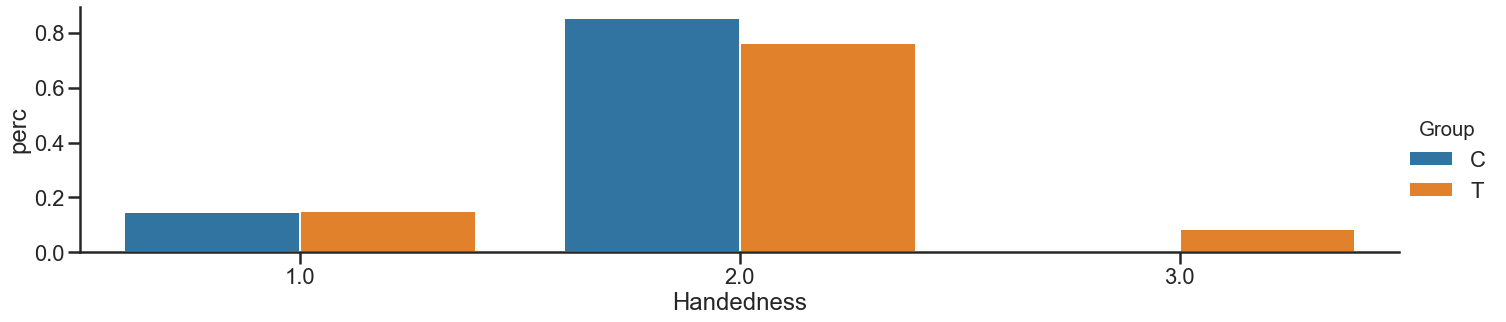



Marital


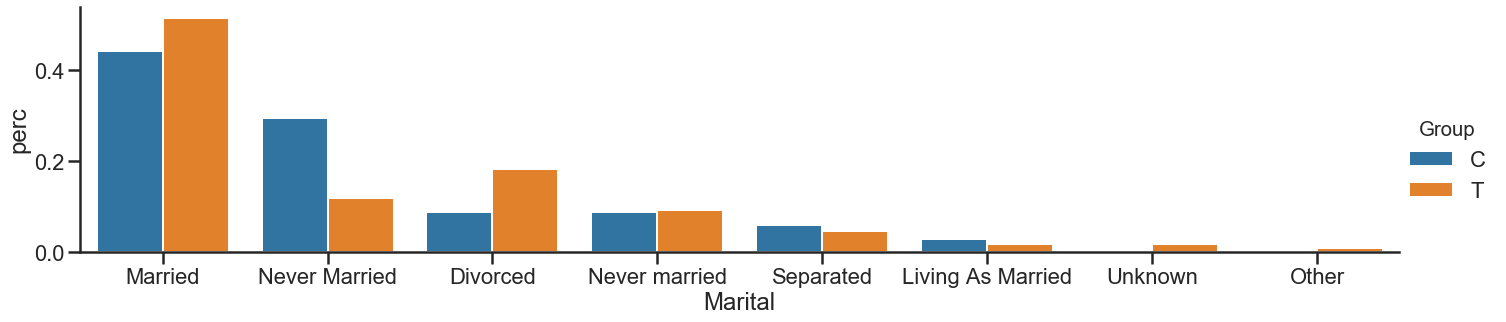



APOEGen


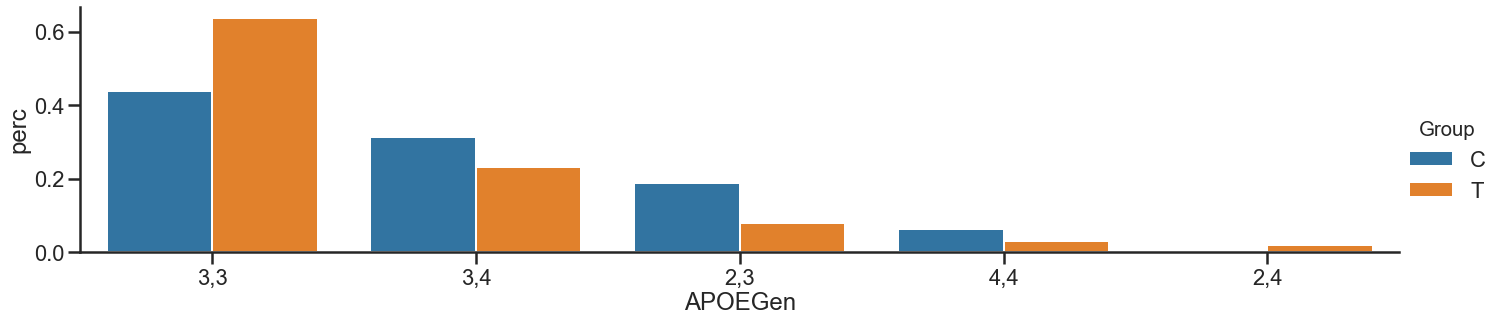



HYPERTEN


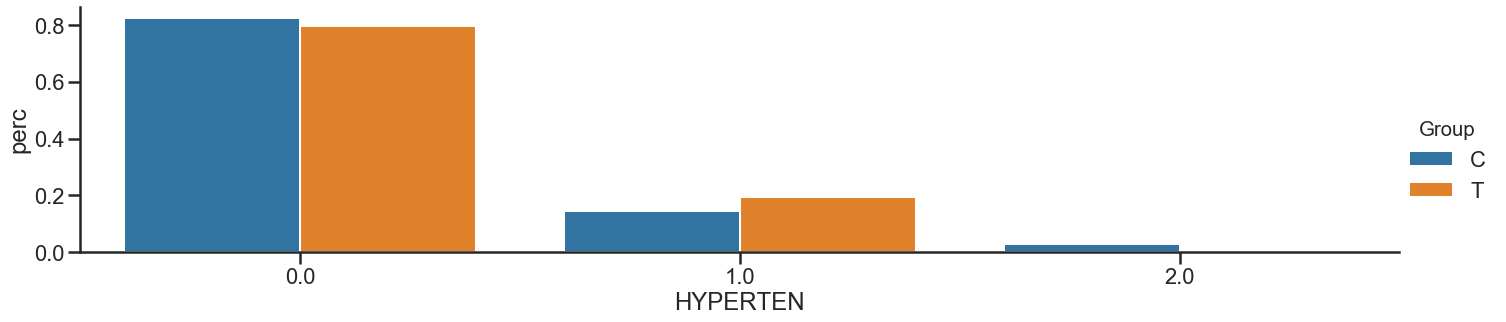



HYPERCHO


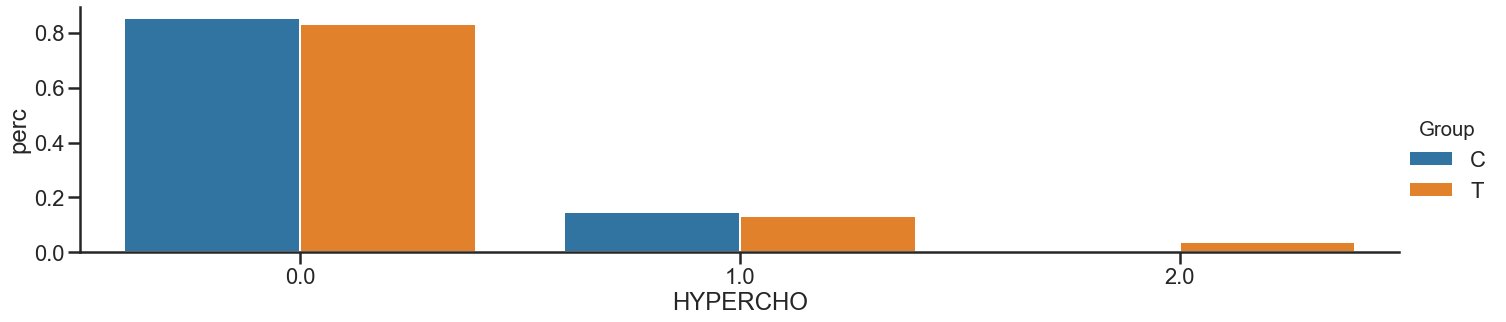



DIABETES


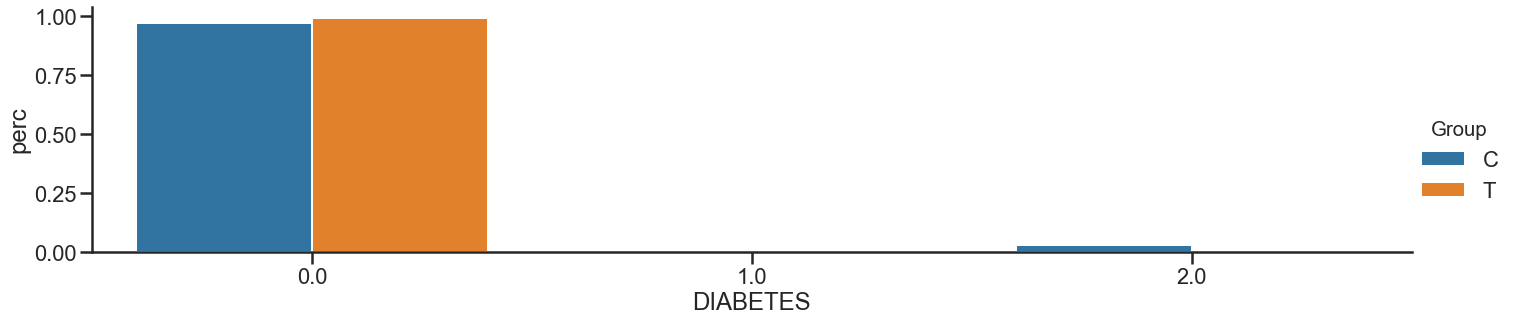



B12DEF


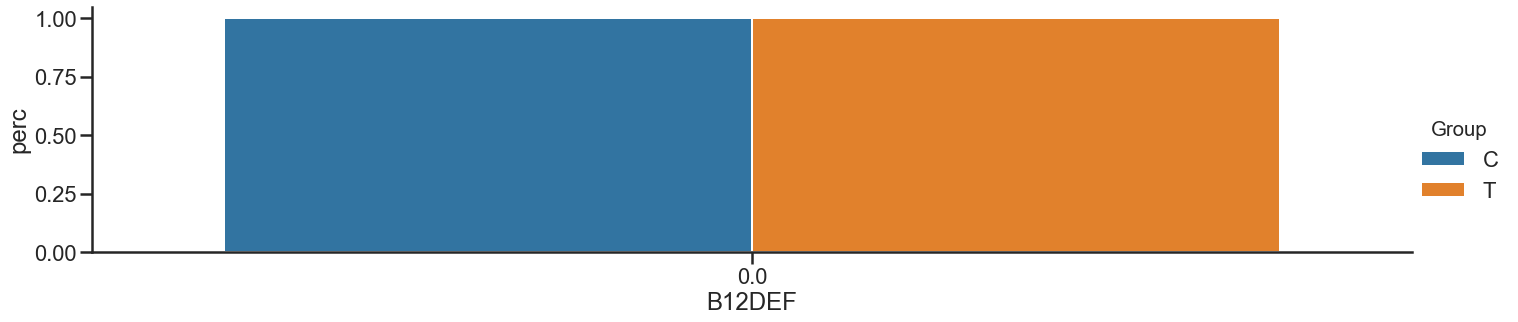



THYROID


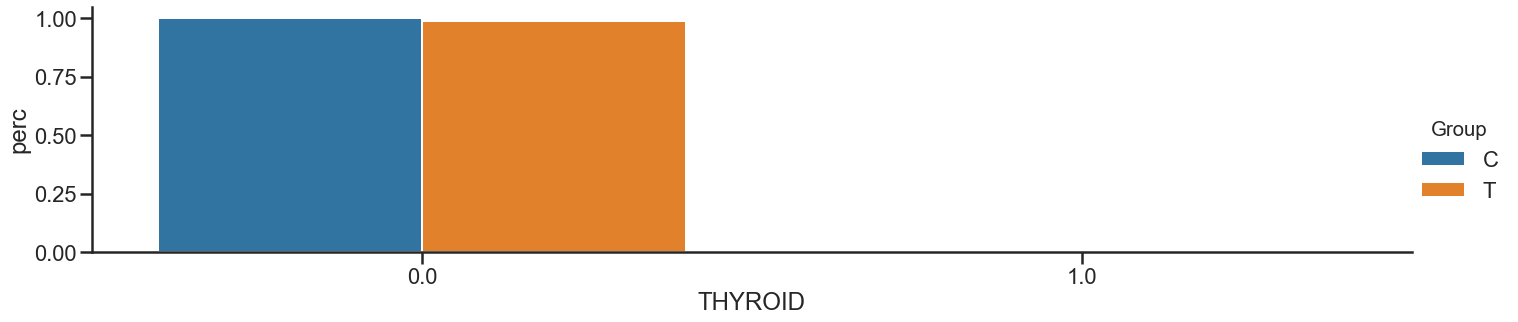



MHxPain


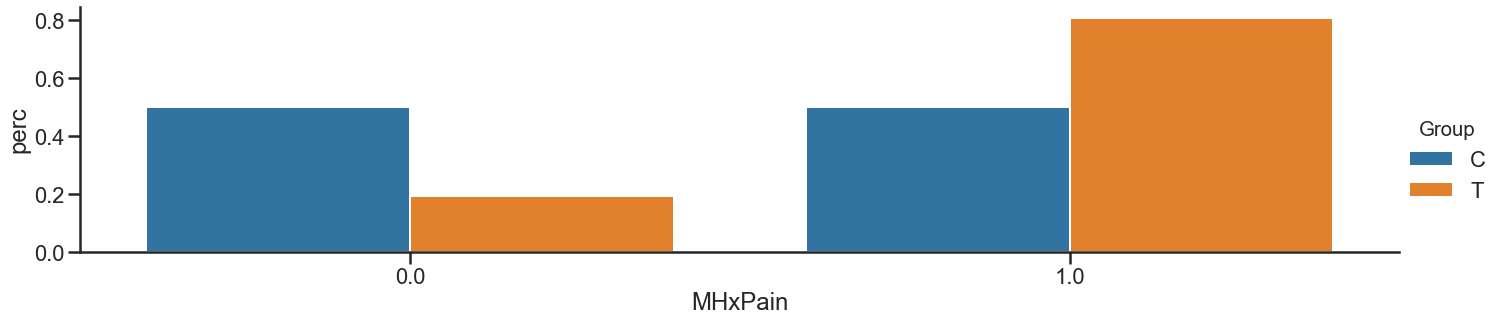



MHxHA


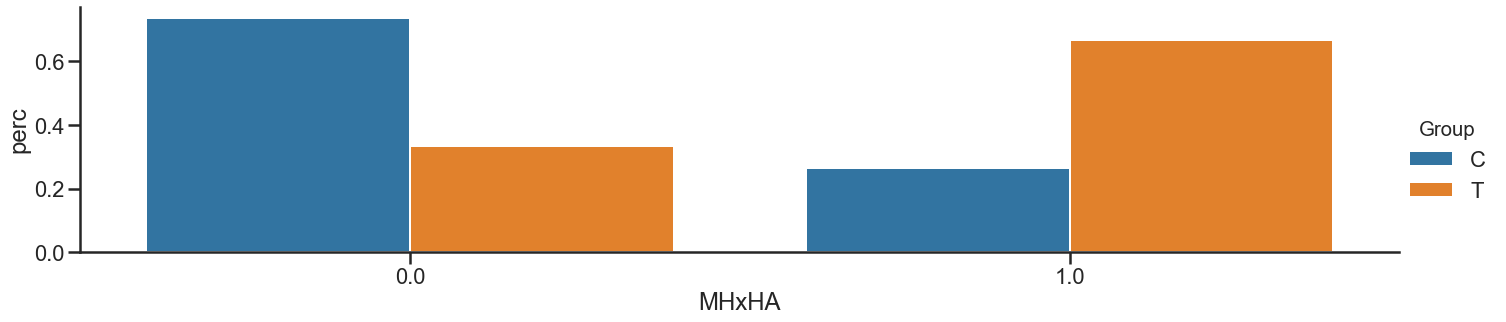



MHxHtn


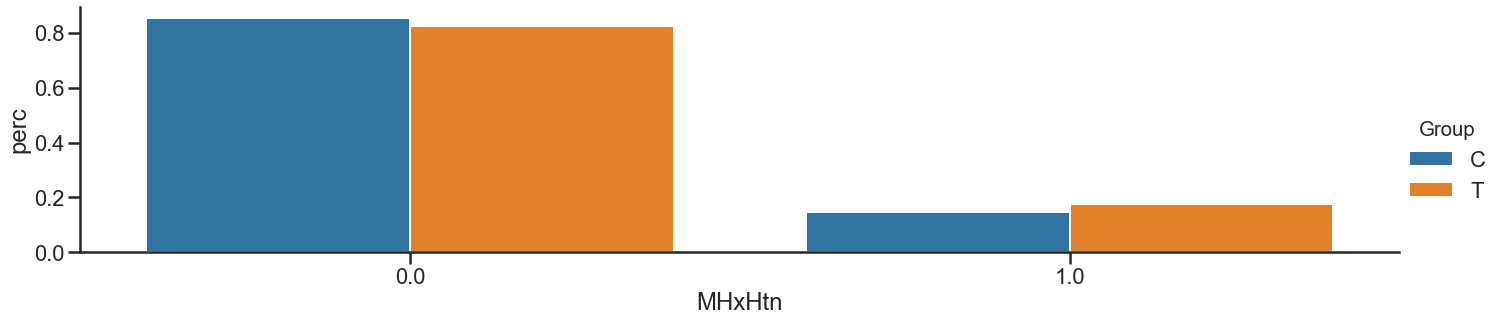



MHxCard


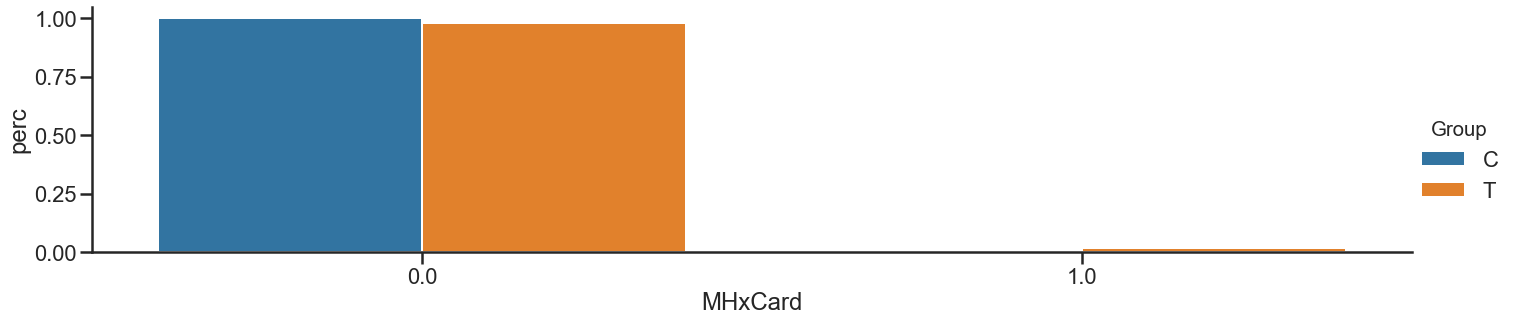



MHxGI


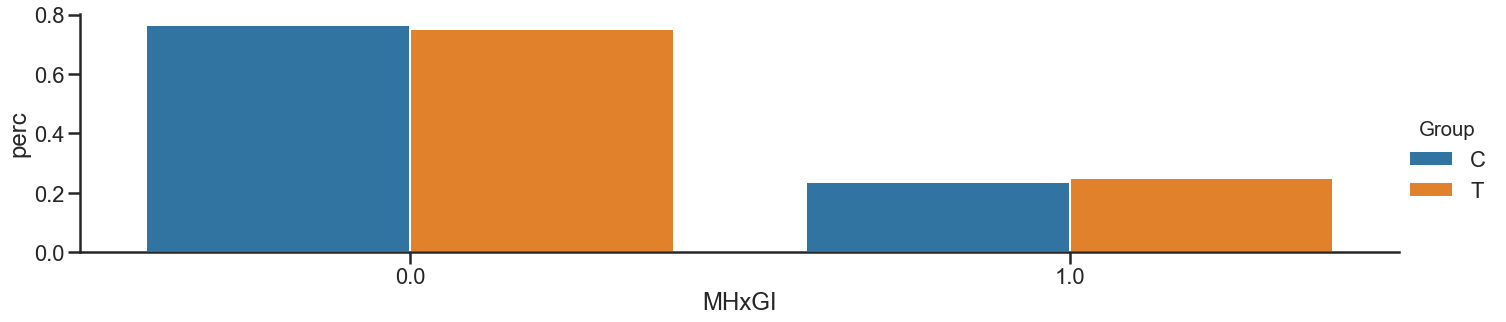



MHxNeuro


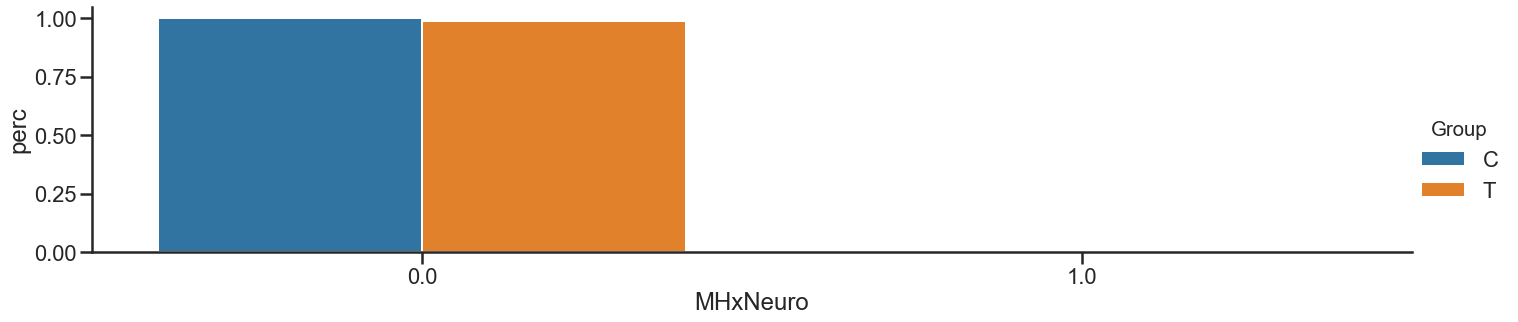



MHxLung


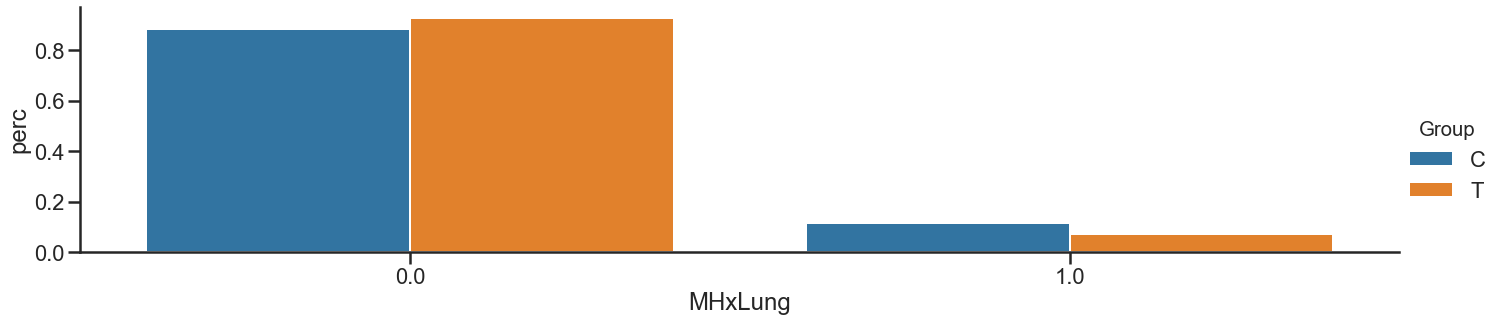



MHxApnea


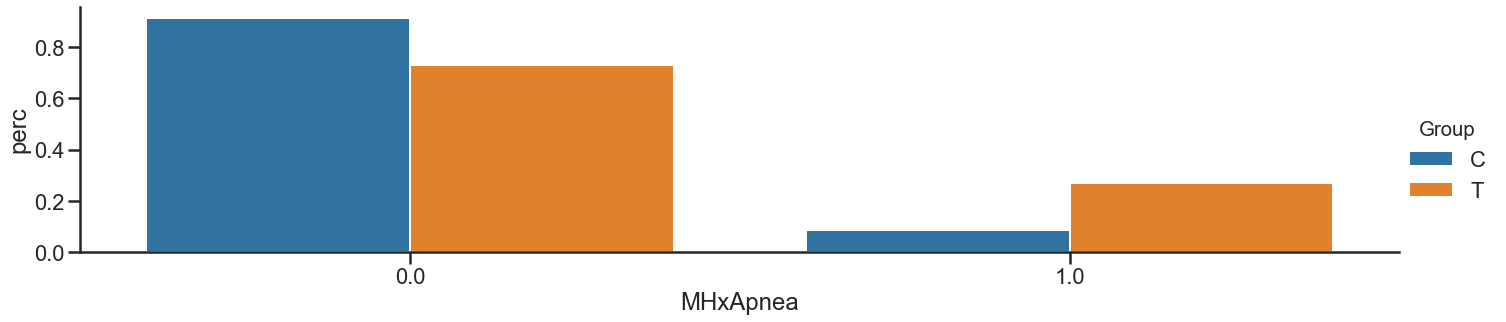



SCPTSD


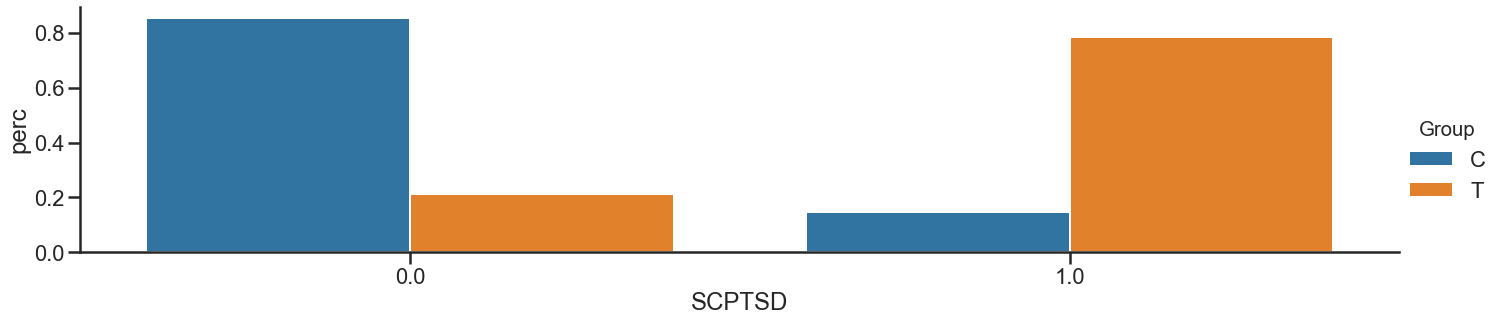



SCMDD


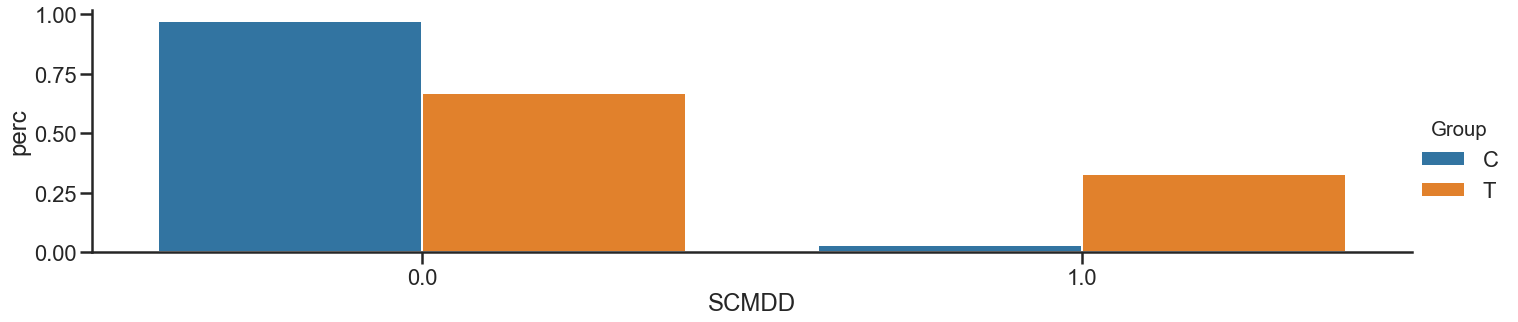



SCPD


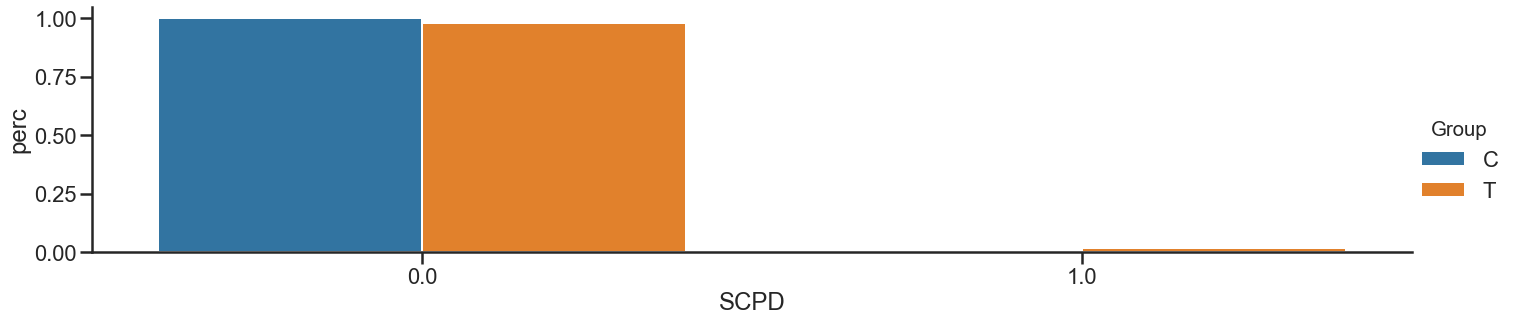



SCGAD


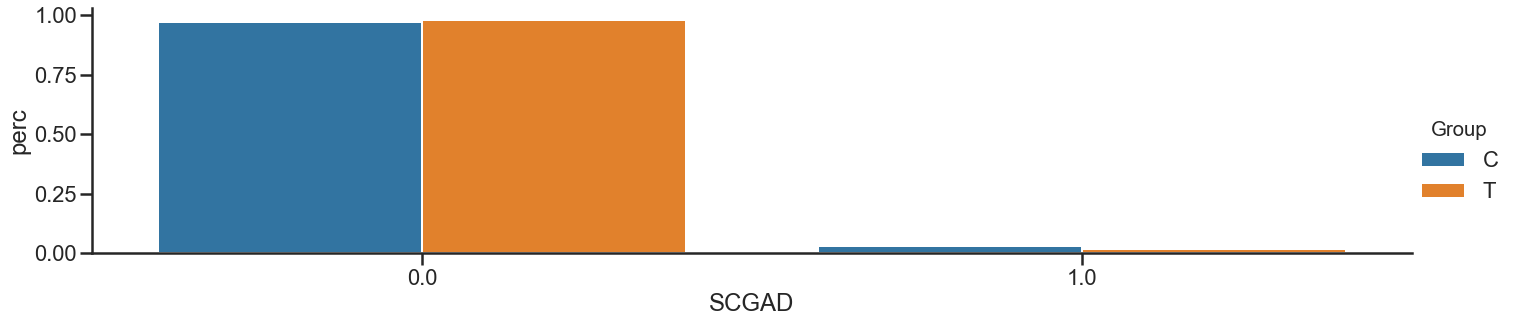



SCNone


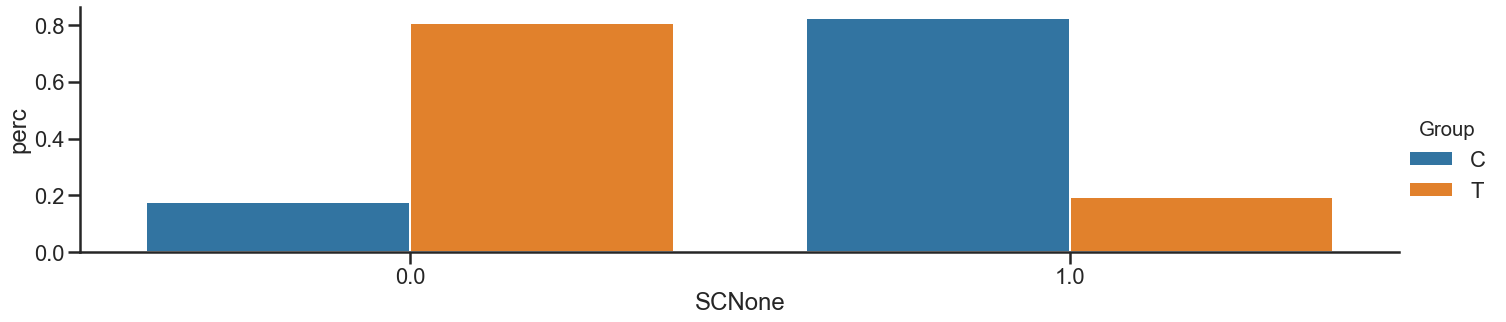



capsCrtA


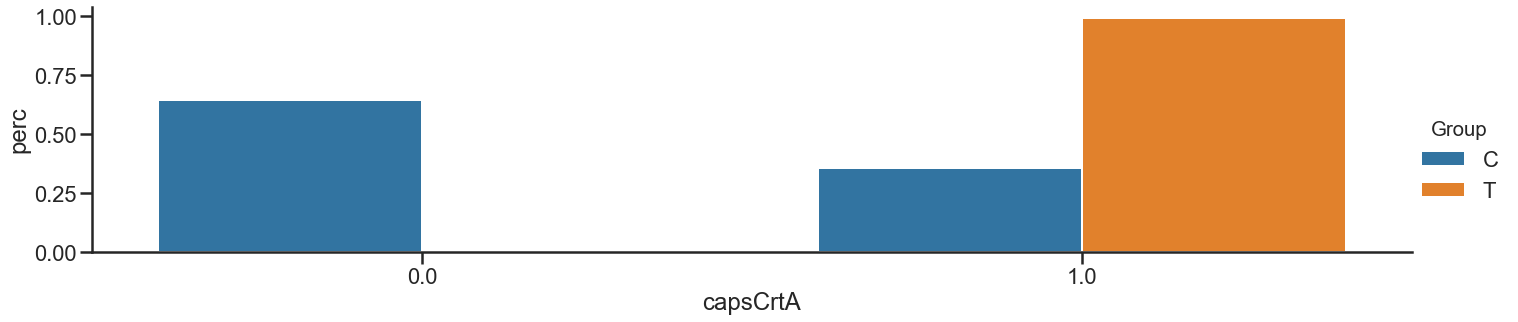

In [6]:
for param in data_cat:
    print(param)

    data_int = (data_v1[data_v1[param] != 9].groupby('Group')[param].value_counts() /
                data_v1[data_v1[param] != 9].groupby('Group')[param].count()).reset_index(name='perc')
        
    try:
        g = sns.catplot(x=param, y='perc', kind='bar', data=data_int, hue='Group', ci=68, height=5, aspect=4)
        plt.show()
        
        print('\n')
        
    except:
        pass
    

In [28]:
sig_params = ['BMI', 'HRATE', 'BGlucose', 'HDL_LDL_ratio', 'CSFGLUCOSE', 
              'servconn', 'cestotal', 'QKOIorA', 'QBlstExp',
              'PCLTot', 'PHQTot', 'PSQItot', 'NSITot', 'TBITot']

data_corr = data_v1[sig_params].corr()
data_corr

,BMI,HRATE,BGlucose,HDL_LDL_ratio,CSFGLUCOSE,servconn,cestotal,QKOIorA,QBlstExp,PCLTot,PHQTot,PSQItot,NSITot,TBITot
BMI,1.000000,0.251472,0.345562,-0.434039,0.133071,0.301869,0.157321,0.119358,-0.003629,0.309315,0.285980,0.157774,0.382294,0.363132
HRATE,0.251472,1.000000,0.138962,-0.499353,-0.028796,0.127312,0.040575,-0.008277,0.179167,0.135866,0.146973,0.195322,0.188283,0.144174
BGlucose,0.345562,0.138962,1.000000,-0.045003,0.154517,0.063364,0.077690,0.108283,0.166733,0.099057,0.166170,-0.036838,0.199549,0.184027
HDL_LDL_ratio,-0.434039,-0.499353,-0.045003,1.000000,-0.014468,-0.278233,-0.142680,0.013703,-0.080917,-0.411067,-0.416320,-0.327256,-0.333560,-0.358857
CSFGLUCOSE,0.133071,-0.028796,0.154517,-0.014468,1.000000,0.207974,0.303808,-0.048794,0.005741,0.181801,0.181396,0.217176,0.184666,0.188158
servconn,0.301869,0.127312,0.063364,-0.278233,0.207974,1.000000,0.470163,0.188276,0.110013,0.598792,0.514049,0.445521,0.617438,0.608847
cestotal,0.157321,0.040575,0.077690,-0.142680,0.303808,0.470163,1.000000,0.392902,0.388810,0.596383,0.445753,0.416769,0.522398,0.528190
QKOIorA,0.119358,-0.008277,0.108283,0.013703,-0.048794,0.188276,0.392902,1.000000,0.428194,0.345220,0.273434,0.200466,0.307356,0.323536
QBlstExp,-0.003629,0.179167,0.166733,-0.080917,0.005741,0.110013,0.388810,0.428194,1.000000,0.216878,0.198465,0.154995,0.180812,0.181473
PCLTot,0.309315,0.135866,0.099057,-0.411067,0.181801,0.598792,0.596383,0.345220,0.216878,1.000000,0.826338,0.692646,0.857808,0.865330


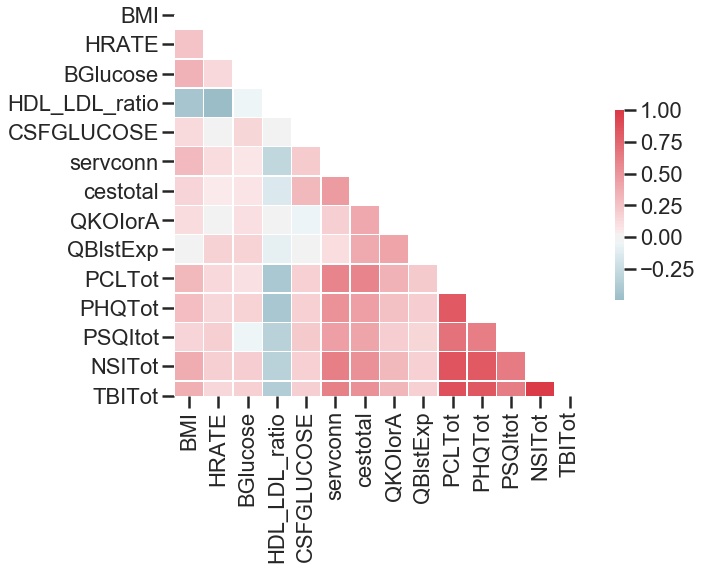

In [29]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
#exclude 3rd visit seq
visits = [1,2]
data_v12 = data[data['VisitSeq'].isin(visits)]
#get TBIIDs of participants with a second visit and use to filter
TBIID_v2 = data_v12[data_v12['VisitSeq'] == 2]['TBIID'].values

#create new column for if came to second visitseq - want to see if params at visitseq 1 map on to whether they came back again
data_v12['visit2'] = [1 if TBIID in TBIID_v2 else 0 for TBIID in data_v12['TBIID']]

#create new df with only participants who came to both visits 1 and 2
data_v12_only = data_v12[data_v12['TBIID'].isin(TBIID_v2)]
print(data_v12_only.shape)
print(data_v12_only.groupby(['VisitSeq', 'Group'])['Group'].value_counts())
data_v12_only.head()

(94, 123)
VisitSeq  Group  Group
1         C      C        13
          T      T        34
2         C      C        13
          T      T        34
Name: Group, dtype: int64


,Status_x,VisitSeq,Group,TBIID,EntityID,DOB,GType,Race,Hispanic,Handedness,ScreenAge,Education,Marital,APOEGen,servconn,cestotal,MnthSncBlst,QKOIorA,QKOExpMil,QKOAllMil,QKOLife,QBlstExp,QBEACRM,Q5plus2,QEDist_sum,QEDist_mean,QEDist_min,auditc,AUDIT1,AUDIT2,AUDIT3,DOPA,DA,DOPAC,NE,DHPG,da_dopa_ratio,dopac_da_ratio,ne_dopa_ratio,dhpg_ne_ratio,HEIGHT,WEIGHT,BMI,BPSYS,BPDIAS,HRATE,HYPERTEN,HYPERCHO,DIABETES,B12DEF,THYROID,BGlucose,BNa,BUN,BCreat,UNa,BK,TotalChol,LDL,HDL,Trig,CSFPROTEIN_x,CSFGLUCOSE,CSFRBCS,MHxPain,MHxHA,MHxHtn,MHxCard,MHxGI,MHxNeuro,MHxLung,MHxApnea,SCPTSD,SCMDD,SCPD,SCGAD,SCNone,DvpHA,DvpHAAct,DvpHASlp,DvpHAMd,DvpHAStr,DvpBP,DvpBPAct,DvpBPslp,DvpBPMd,DvpBPStr,BISAtt,BISMtr,BISNonpl,BISTot,capsCrtA,CAPSTotal,PSQIc1,PSQIc2,PSQIc3,PSQIc4,PSQIc5,PSQIc6,PSQIc7,PSQItot,PCLTot,PCL_reexp,PCL_avoid,PCL_numb,PCL_hyper,PHQTot,PHQ_psych,PHQ_somatic,NSITot,TBITot,NSI_vestibular,NSI_somatosensory,NSI_cognitive,NSI_affective,NSI_ERP_affective,NIS_ERP_vestsom,PreSleep,PreCaff,PreETOH,PreNic,PreTHC,visit2
4,Active,1,C,C006,2989,1956-10-21,M12,White,1.0,2.0,38,12.0,Divorced,"3,3",0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,4.0,1.0,2.0,1.0,511.0,6.0,158.0,96.0,1643.0,0.011742,26.333333,0.187867,17.114583,70.0,195.0,28.0,142.0,90.0,67.0,1.0,0.0,0.0,0.0,0.0,89.0,142.0,19.0,0.86,NaN,4.2,NaN,NaN,NaN,NaN,25.0,59.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,2.0,1.0,0.0,1.0,0.0,1.0,6.0,27.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,9.0,9.0,0.666667,0.142857,0.75,0.500000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1
7,Active,1,C,C009,2992,1965-04-23,M16,Black/African American,0.0,2.0,30,16.0,Never Married,"3,4",10.0,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0,2.0,0.0,0.0,435.0,NaN,430.0,71.0,1633.0,NaN,NaN,0.163218,23.000000,71.0,176.0,24.5,122.0,76.0,66.0,0.0,1.0,0.0,0.0,0.0,89.0,138.0,16.0,1.37,NaN,4.3,NaN,NaN,NaN,NaN,26.0,61.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,1.0,1.0,1.0,1.0,2.0,1.0,9.0,29.0,1.0,1.0,2.6,1.8,12.0,1.5,1.2,16.0,17.0,0.000000,0.000000,2.00,1.333333,0.0,0.5,NaN,NaN,NaN,NaN,NaN,1
9,Inactive,1,C,C011,3017,1971-05-29,M13,White,0.0,2.0,24,13.0,Never Married,"3,4",20.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,5.0,2.0,2.0,1.0,458.0,5.0,596.0,124.0,1987.0,0.010917,119.200000,0.270742,16.024194,76.0,215.0,26.2,135.0,65.0,45.0,0.0,0.0,0.0,0.0,0.0,87.0,137.0,16.0,0.98,NaN,3.9,NaN,NaN,NaN,NaN,35.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,17.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1
10,Active,1,C,C012,3146,1968-10-25,M13,White,0.0,2.0,27,13.0,Married,"3,4",0.0,3.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0,2.0,0.0,0.0,621.0,111.0,256.0,138.0,2550.0,0.178744,2.306306,0.222222,18.478261,73.0,172.0,22.7,135.0,80.0,67.0,1.0,0.0,0.0,0.0,0.0,80.0,139.0,14.0,0.91,NaN,4.1,NaN,NaN,NaN,NaN,76.0,56.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,2.0,1.0,0.0,0.0,4.0,20.0,1.2,1.5,1.2,1.0,1.0,0.0,0.2,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1
12,Completed,1,C,C015,3320,1958-04-03,M14,White,0.0,2.0,37,14.0,Married,"3,4",0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0,2.0,0.0,0.0,831.0,9.0,654.0,180.0,2906.0,0.010830,72.666667,0.216606,16.144444,69.0,185.0,27.3,122.0,75.0,62.0,0.0,0.0,0.0,0.0,0.0,143.0,138.0,13.0,0.82,NaN,3.4,NaN,NaN,NaN,NaN,28.0,60.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,18.0,1.0,1.0,1.2,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.25,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1
